# Practice problems 7
# [Machine Learning](https://dis.unal.edu.co/~fgonza/)

The following code implements a feed-forward neural network with one hidden layer:

In [2]:
import os
from dotenv import load_dotenv
import absl.logging as absl_logging
import numpy as np
import pylab as pl
import sys
import subprocess
import tensorflow as tf

# Carga variables del .env
load_dotenv()

# Configura rutas de CUDA desde el .env
cuda_home = os.getenv("CUDA_HOME")
cuda_bin = os.getenv("CUSTOM_CUDA_PATH")
cuda_lib = os.getenv("CUSTOM_CUDA_LIB_PATH")

# Configura logs de TensorFlow y CUDA
os.environ["TF_CPP_MIN_LOG_LEVEL"] = os.getenv("TF_CPP_MIN_LOG_LEVEL", "3")
os.environ["CUDA_LOG_LEVEL"] = os.getenv("CUDA_LOG_LEVEL", "1")
os.environ["CUDA_DEVICE_LOG_LEVEL"] = os.getenv("CUDA_DEVICE_LOG_LEVEL", "1")
os.environ["NVIDIA_LOG_LEVEL"] = os.getenv("NVIDIA_LOG_LEVEL", "ERROR")

# Configura qué GPUs usar (si está en el .env)
cuda_visible_devices = os.getenv("CUDA_VISIBLE_DEVICES")
if cuda_visible_devices is not None:
    os.environ["CUDA_VISIBLE_DEVICES"] = cuda_visible_devices

# Configura el PATH y LD_LIBRARY_PATH para CUDA
if cuda_bin:
    os.environ["PATH"] = f"{cuda_bin}:{os.environ.get('PATH', '')}"

if cuda_lib:
    os.environ["LD_LIBRARY_PATH"] = f"{cuda_lib}:{os.environ.get('LD_LIBRARY_PATH', '')}"

# Configura absl logging lo antes posible
os.environ["ABSL_LOG_LEVEL"] = os.getenv("ABSL_LOG_LEVEL", "3")
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging.use_absl_handler()

Some auxiliar functions

In [3]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def predict(w, x):
    a = np.zeros((3,))
    a[2] = relu(np.dot(x,w[6:8]) + w[8])
    a[1] = relu(np.dot(x,w[3:5]) + w[5])
    a[0] = sigmoid(np.dot(a[1:3], w[0:2]) + w[2])
    return a[0]

def pick_device():
    if tf.config.list_physical_devices('GPU'):
        return '/GPU:0'
    else:
        return '/CPU:0'

In [4]:
def plot_data(X, y, title = "Data"):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title(title)

def plot_decision_region(X, pred_fun, vmin=-2, vmax=2):
    """
    X: corresponde a las instancias de nuestro conjunto de datos
    pred_fun: es una función que para cada valor de X, me regresa una predicción
    """
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 60)
    y_vals = np.linspace(min_y, max_y, 60)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin=vmin, vmax=vmax)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

def plot_decision_region_tf(X, model, vmin=-2, vmax=2):
    """
    X: corresponde a las instancias de nuestro conjunto de datos
    model: Modelo de TensorFlow que se usará para hacer las predicciones
    """
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    range_x = max_x - min_x
    range_y = max_y - min_y
    min_x -= 0.05 * range_x
    max_x += 0.05 * range_x
    min_y -= 0.05 * range_y
    max_y += 0.05 * range_y

    x_vals = np.linspace(min_x, max_x, 60)
    y_vals = np.linspace(min_y, max_y, 60)
    XX, YY = np.meshgrid(x_vals, y_vals)
    
    grid_points = np.c_[XX.ravel(), YY.ravel()]

    preds = model.predict(grid_points)
    
    if preds.ndim > 1 and preds.shape[1] == 1:
        preds = preds.flatten()

    ZZ = preds.reshape(XX.shape)

    pl.contourf(XX, YY, ZZ, 30, cmap=pl.cm.coolwarm, vmin=vmin, vmax=vmax)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1.
Find a weight vector such that the neural network calculates the negated XOR function:
    
$$f(x,y)=\neg(x\text{ xor }y)$$

Use the following function to test your answer:

[0, 0] -> 1.0000
[0, 1] -> 0.0000
[1, 0] -> 0.0000
[1, 1] -> 1.0000


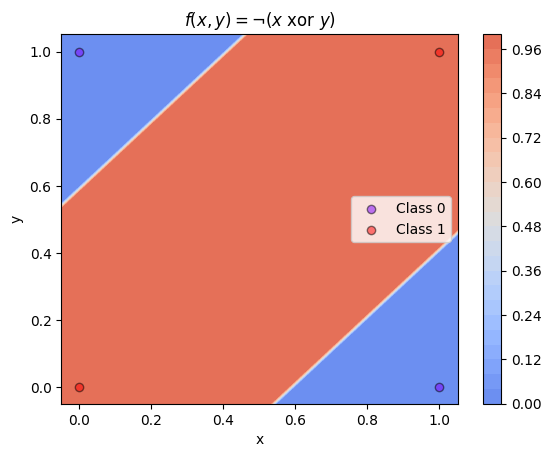

In [5]:
def test_prediction(X, Y, w):
    epsilon = 0.001
    for i, x in enumerate(X):
        print (f'{x} -> {predict(w, x):.4f}')
        if np.abs(predict(w, x) - Y[i]) > epsilon:
            raise Exception("Prediction error")
    return True

w = np.array([-35,-35,20,
              -35,35,-20,
              35,-35,-20])

X = [[0, 0],
    [0, 1],
    [1, 0],
    [1, 1]]
Y = [1, 0, 0 ,1]
f = lambda x, y: predict(w, np.array([x, y]))
plot_decision_region(np.array(X), f,vmin=-.2, vmax=1.2)
plot_data(np.array(X), np.array(Y), title=r"$f(x,y)=\neg(x\text{ xor }y)$")
try: 
    test_prediction(X, Y, w)
except Exception as e:
    print(e)

### 2.

Suppose that we have a cross entropy loss function:

$$L(w, x, y) = - y \log f_w(x) - (1-y) \log (1-f_w(x))$$

where $f_w(x)$ corresponds to the prediction of the neural network from the  previous question.

In [6]:
def loss(w, x, y):
    return -y * np.log(predict(w, x)) -(1. - y) * np.log(1. - predict(w, x))

Write a function that calculates the gradient of the loss with respect to the weights:

$$ \frac{\partial L}{\partial w} $$

In order to do this, we will use backpropagation, and we will find the values for the $\delta_i$ defined in the following schema:

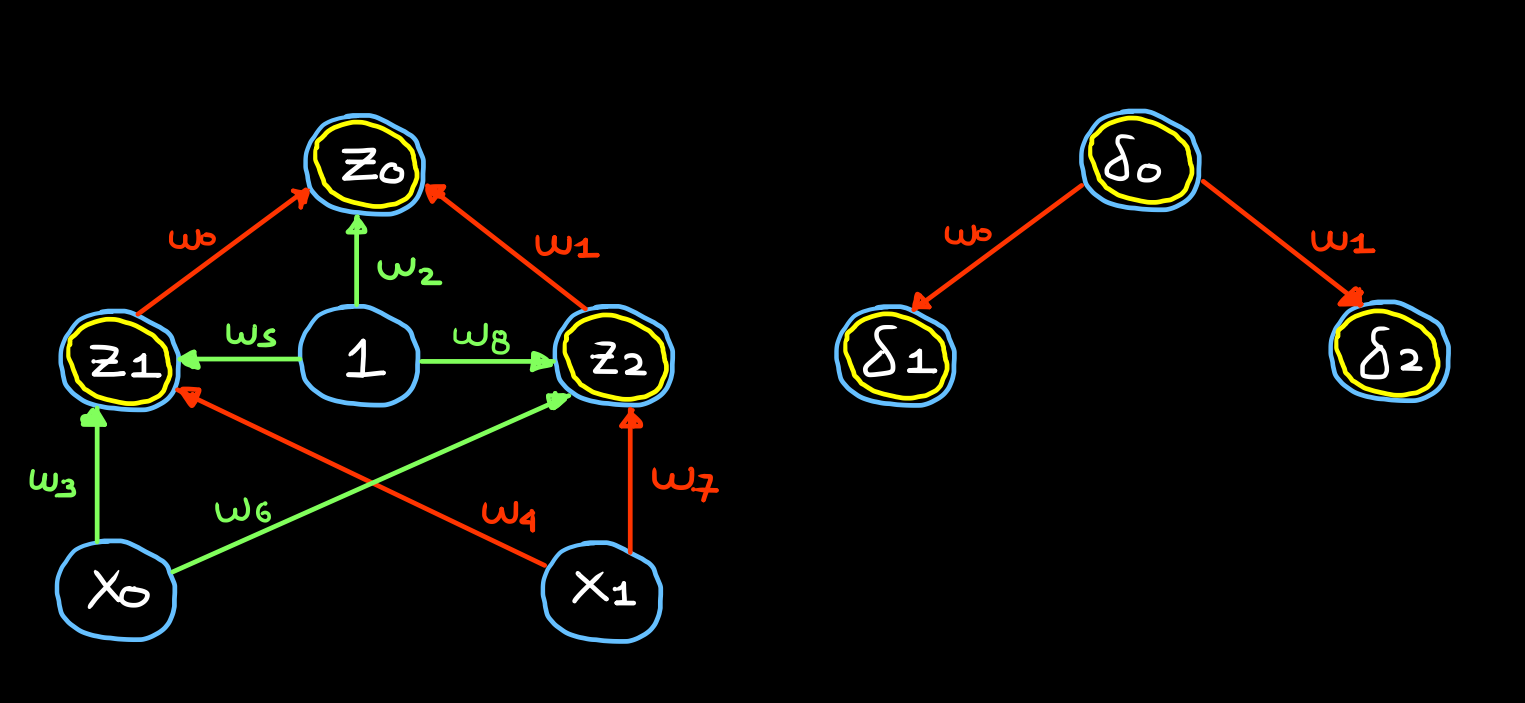

Using the relationships shown by the network, we will find the values pf $\delta_i$ and compute the gradients using:

$$\nabla w_{ji} = \delta_{j} z_{i}$$

Where $w_{ji}$ is the weight that is related to the directed connection between neuron $z_i$ and $z_j$

In [7]:
def dL_dw(w, x, y):

    if y.ndim == 1: y = y[0]

    def derivative_relu(x):
        return 1 if x > 0 else 0
    
    #Forwad pass
    z = np.zeros((3,))
    a = np.zeros((3,))
    a[2] = np.dot(x,w[6:8]) + w[8]
    z[2] = relu(a[2])
    a[1] = np.dot(x,w[3:5]) + w[5]
    z[1] = relu(a[1])
    a[0] = np.dot(z[1:3], w[0:2]) + w[2]
    z[0] = sigmoid(a[0])
    
    #Backward pass
    delta = np.zeros((3,))
    delta[0] = z[0] - y
    delta[1] = derivative_relu(a[1]) * (np.dot(delta[0], w[0]))
    delta[2] = derivative_relu(a[2]) * (np.dot(delta[0], w[1]))

    #Grad for the different weights
    grad = np.zeros_like(w)
    grad[0:2] = delta[0] * z[1:3]        #    z1 ---w0--> z0   , z2 ---w1--> z0
    grad[2] = delta[0]                   #    (1) --w2--> z0
    grad[3:5] = delta[1] * x             #    x0 ---w3--> z1   , x1 ---w4--> z1
    grad[5] = delta[1]                   #    (1) --w5--> z1
    grad[6:8] = delta[2] * x             #    x0 ---w6--> z2   , x1 ---w7--> z2
    grad[8] = delta[2]                   #    (1) --w8--> z2

    return grad

Use the following functions to test your code:

In [8]:
tws = np.array([[-0.70032787,  0.05195189,  0.02322052,  1.4555916 ,  0.12168937,
        -0.93580307, -0.58649814, -0.25847014, -0.11531032],
       [ 1.11732048,  0.60225913,  0.05929297, -1.09018787,  2.33186956,
         0.68248461, -0.16774443, -0.12996126,  0.31700533],
       [ 0.80285183,  0.08585098,  1.62153749,  0.61251705,  0.18263732,
         2.08412764, -0.2940164 , -0.72975557, -1.33828478],
       [-0.74973286,  1.24623671,  0.63761743,  2.13714693,  0.90258674,
         1.70238408, -2.60308453,  0.03070776,  2.34519973]])
txs = np.array([[-0.96460511,  0.79790901],
       [ 0.34546505,  0.92062212],
       [-0.85750439,  0.50268203],
       [ 0.69988938,  2.07328522]])
tys = np.array([[ 0.66453404],
       [-1.35012527],
       [-0.7976646 ],
       [ 0.57095802]])
tls = np.array([[ 0.        , -0.03798627, -0.1555583 ,  0.        ,  0.        ,
         0.        ,  0.0077955 , -0.00644834, -0.00808155],
       [ 5.63408329,  0.32024725,  2.29715661,  0.88669136,  2.36292409,
         2.56666012,  0.47794521,  1.27366556,  1.38348354],
       [ 2.8850554 ,  0.        ,  1.74777687, -1.20325518,  0.70536637,
         1.40320586,  0.        ,  0.        ,  0.        ],
       [-2.48486794, -0.2877231 , -0.49016324,  0.25720339,  0.76191466,
         0.36749148, -0.42753402, -1.26648581, -0.61085942]])

def test_dL_dw():
    num_tests = tws.shape[0]
    epsilon = 0.0001
    for i in range(num_tests):
        tw = tws[i]
        tx = txs[i]
        ty = tys[i]
        tl = tls[i]
        if np.linalg.norm(dL_dw(tw, tx, ty) - tl) > epsilon:
            raise Exception("dL_dw test failed!")
    return True

test_dL_dw()

True

As a new experiment, we will try to get the best weights of the first task using gradient descent

In [9]:
X = [[0, 0],
    [0, 1],
    [1, 0],
    [1, 1]]
Y = [1, 0, 0 ,1]

X = np.array(X)
Y = np.array(Y)

w = np.array([
    1,1,1,
    1,-1,1,
    -1,1,1
])

w = w / np.abs(w).min()

print("Initial weights")
print(f'[ {", ".join(w.round(3).astype(str))} ]\n')

lr = 0.6
n_epochs = 1501
for epoch in range(n_epochs):
    delta_cum = np.zeros_like(w)
    loss_cum = 0
    for i, x in enumerate(X):
        loss_cum += loss(w, x, Y[i])
    for i, x in enumerate(X):
        w = w - lr * dL_dw(w, x, Y[i])
    if epoch%100 == 0: print(f"Epoch {epoch:>5}: --> loss = {loss_cum:.5f}")

Initial weights
[ 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0 ]

Epoch     0: --> loss = 6.19435
Epoch   100: --> loss = 0.03280
Epoch   200: --> loss = 0.01421
Epoch   300: --> loss = 0.00889
Epoch   400: --> loss = 0.00647
Epoch   500: --> loss = 0.00508
Epoch   600: --> loss = 0.00416
Epoch   700: --> loss = 0.00352
Epoch   800: --> loss = 0.00306
Epoch   900: --> loss = 0.00270
Epoch  1000: --> loss = 0.00241
Epoch  1100: --> loss = 0.00217
Epoch  1200: --> loss = 0.00198
Epoch  1300: --> loss = 0.00182
Epoch  1400: --> loss = 0.00169
Epoch  1500: --> loss = 0.00157


Final weights
[ -4.593, -4.576, 7.293, 3.588, -3.588, 0.0, -3.602, 3.601, -0.001 ]

[0 0] -> 0.9993
[0 1] -> 0.0001
[1 0] -> 0.0001
[1 1] -> 0.9993


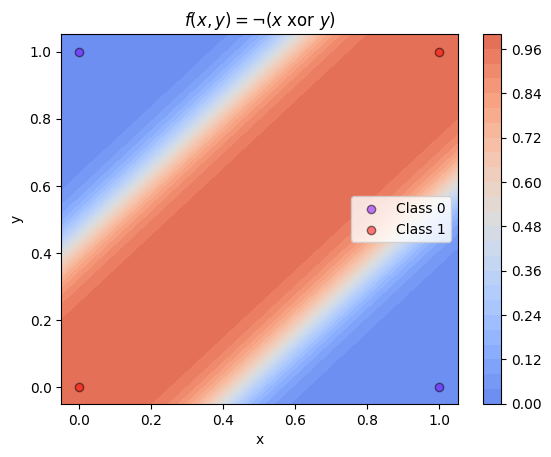

In [10]:
print("Final weights")
print(f'[ {", ".join(w.round(3).astype(str))} ]\n')

f = lambda x, y: predict(w, np.array([x, y]))
plot_decision_region(np.array(X), f,vmin=-.2, vmax=1.2)
plot_data(np.array(X), np.array(Y), title=r"$f(x,y)=\neg(x\text{ xor }y)$")
try: 
    test_prediction(X, Y, w)
except Exception as e:
    print(e)

Finally, we will attempt to solve the same task using the tensorflow implementation

In [11]:
def get_cuda_info():
    try:
        # GPUs detectados
        gpus = tf.config.list_physical_devices('GPU')
        if not gpus:
            print("No GPUs found in the system")
            return
        
        print(f"Number of GPUs: {len(gpus)}")
        for gpu in gpus:
            print(f"GPU name: {gpu.name}")
            print(f"GPU type: {gpu.device_type}")

        # CUDA info desde TensorFlow
        build_info = tf.sysconfig.get_build_info()
        cuda_version = build_info.get("cuda_version", "Unknown")
        cudnn_version = build_info.get("cudnn_version", "Unknown")
        print(f"CUDA version (from tf.sysconfig): {cuda_version}")
        print(f"cuDNN version (from tf.sysconfig): {cudnn_version}")

        # Complemento: info desde nvcc y nvidia-smi
        print("\nNvidia CUDA compiler version:")
        subprocess.run("nvcc --version", shell=True)
        
        print("\nNvidia GPU info:")
        subprocess.run("nvidia-smi", shell=True)

        tf.config.optimizer.set_jit(True)

    except Exception as e:
        print(f"Error accessing GPU information: {str(e)}")
        print("Please ensure your GPU is properly configured.")

In [12]:
print("=== TensorFlow Version ===")
print(f"TensorFlow version: {tf.__version__}")

print("\n=== CUDA Information ===")
get_cuda_info()

print("\n=== Python Version ===")
print(f"Python version: {sys.version}")

print("\n=== XLA Status ===")
print(f"XLA enabled: {tf.config.optimizer.get_jit()}")

=== TensorFlow Version ===
TensorFlow version: 2.19.0

=== CUDA Information ===
Number of GPUs: 1
GPU name: /physical_device:GPU:0
GPU type: GPU
CUDA version (from tf.sysconfig): 12.5.1
cuDNN version (from tf.sysconfig): 9

Nvidia CUDA compiler version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Apr_17_19:19:55_PDT_2024
Cuda compilation tools, release 12.5, V12.5.40
Build cuda_12.5.r12.5/compiler.34177558_0

Nvidia GPU info:
Thu May 29 21:59:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.03              Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                           

In [13]:
def initialize_model_weights(model, w):
    model.build(input_shape=(None, 2))
    hidden_kernel = np.column_stack((w[3:5], w[6:8]))
    hidden_bias = w[[5, 8]]
    output_kernel = w[0:2].reshape((2, 1)) 
    output_bias = w[2:3]
    model.layers[0].set_weights([hidden_kernel, hidden_bias])
    model.layers[1].set_weights([output_kernel, output_bias])
    return model

def log_to_str(logs):
    return ', '.join([f"{k}: {v:.5f}" for k, v in logs.items()])

def test_prediction_tf(model, X, Y):
    epsilon = 0.001
    predictions = model.predict(X)
    for i, x in enumerate(X):
        print(f'{x} -> {predictions[i][0]:.4f}')
        if np.abs(predictions[i][0] - Y[i]) > epsilon:
            raise Exception("Prediction error")
    return True

class CustomEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, interval=10000):
        super().__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % self.interval == 0:
            print(f"Epoch {epoch:>5}: {log_to_str(logs)}")

device = pick_device()
print(f"Using device: {device}")

Using device: /GPU:0


In [22]:
with tf.device(device):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    w = np.array([
        1,1,1,
        1,-1,1,
        -1,1,1
    ])

    w = w / np.abs(w).min()
    model = initialize_model_weights(model, w)

    learning_rate = 0.6
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
with tf.device(device):
    losses = model.fit(
        X, Y,
        epochs=1501,
        batch_size=1,
        callbacks=[CustomEpochLogger(interval=100)],
        verbose=0
    )

Epoch     0: accuracy: 0.25000, loss: 1.78141
Epoch   100: accuracy: 1.00000, loss: 0.00778
Epoch   200: accuracy: 1.00000, loss: 0.00346
Epoch   300: accuracy: 1.00000, loss: 0.00220
Epoch   400: accuracy: 1.00000, loss: 0.00160
Epoch   500: accuracy: 1.00000, loss: 0.00126
Epoch   600: accuracy: 1.00000, loss: 0.00103
Epoch   700: accuracy: 1.00000, loss: 0.00088
Epoch   800: accuracy: 1.00000, loss: 0.00076
Epoch   900: accuracy: 1.00000, loss: 0.00067
Epoch  1000: accuracy: 1.00000, loss: 0.00060
Epoch  1100: accuracy: 1.00000, loss: 0.00054
Epoch  1200: accuracy: 1.00000, loss: 0.00049
Epoch  1300: accuracy: 1.00000, loss: 0.00045
Epoch  1400: accuracy: 1.00000, loss: 0.00042
Epoch  1500: accuracy: 1.00000, loss: 0.00039


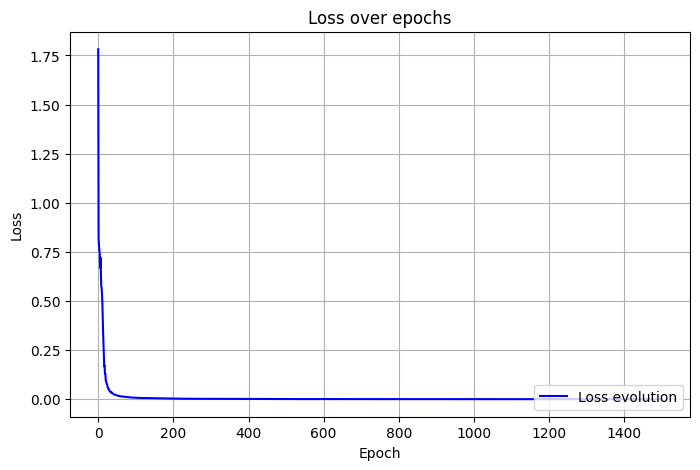

In [28]:
losses_ = losses.history['loss']
pl.figure(figsize=(8, 5))
pl.plot(losses_, label='Loss evolution', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('Loss over epochs')
pl.legend(loc="lower right")
pl.grid(True)
pl.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
[0 0] -> 0.9993
[0 1] -> 0.0001
[1 0] -> 0.0001
[1 1] -> 0.9993


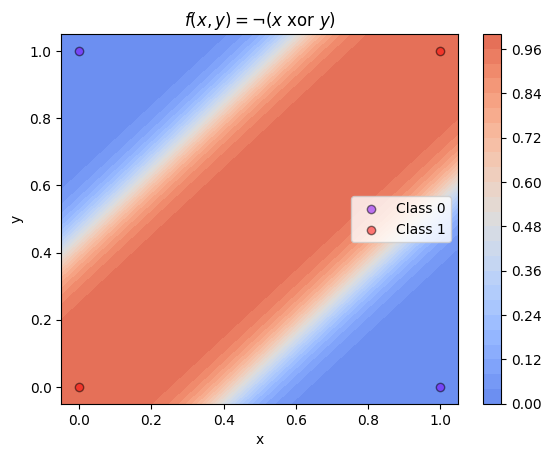

In [29]:
plot_decision_region_tf(np.array(X), model,vmin=-.2, vmax=1.2)
test_prediction_tf(model,X, Y)
plot_data(np.array(X), np.array(Y), title=r"$f(x,y)=\neg(x\text{ xor }y)$")

### 3.

Given a neural network with weights $w$ and and output neuron $y$, find the input vector $x$, that maximizes the output $y$. To do this we need to find the gradient of $y$ with respect to each input:

$$    \nabla_{\mathbf{x}} y = \begin{bmatrix} \frac{\partial y}{\partial x_0} \\ \frac{\partial y}{\partial x_1} \end{bmatrix} $$

Write a function that uses backpropagation to calculate these derivatives given the weights of the neural network.

In order to complete this task, we modify our network diagram so that we could describe the components of the input (Baptised as $x_0$ and $x_1$) as weights of a net

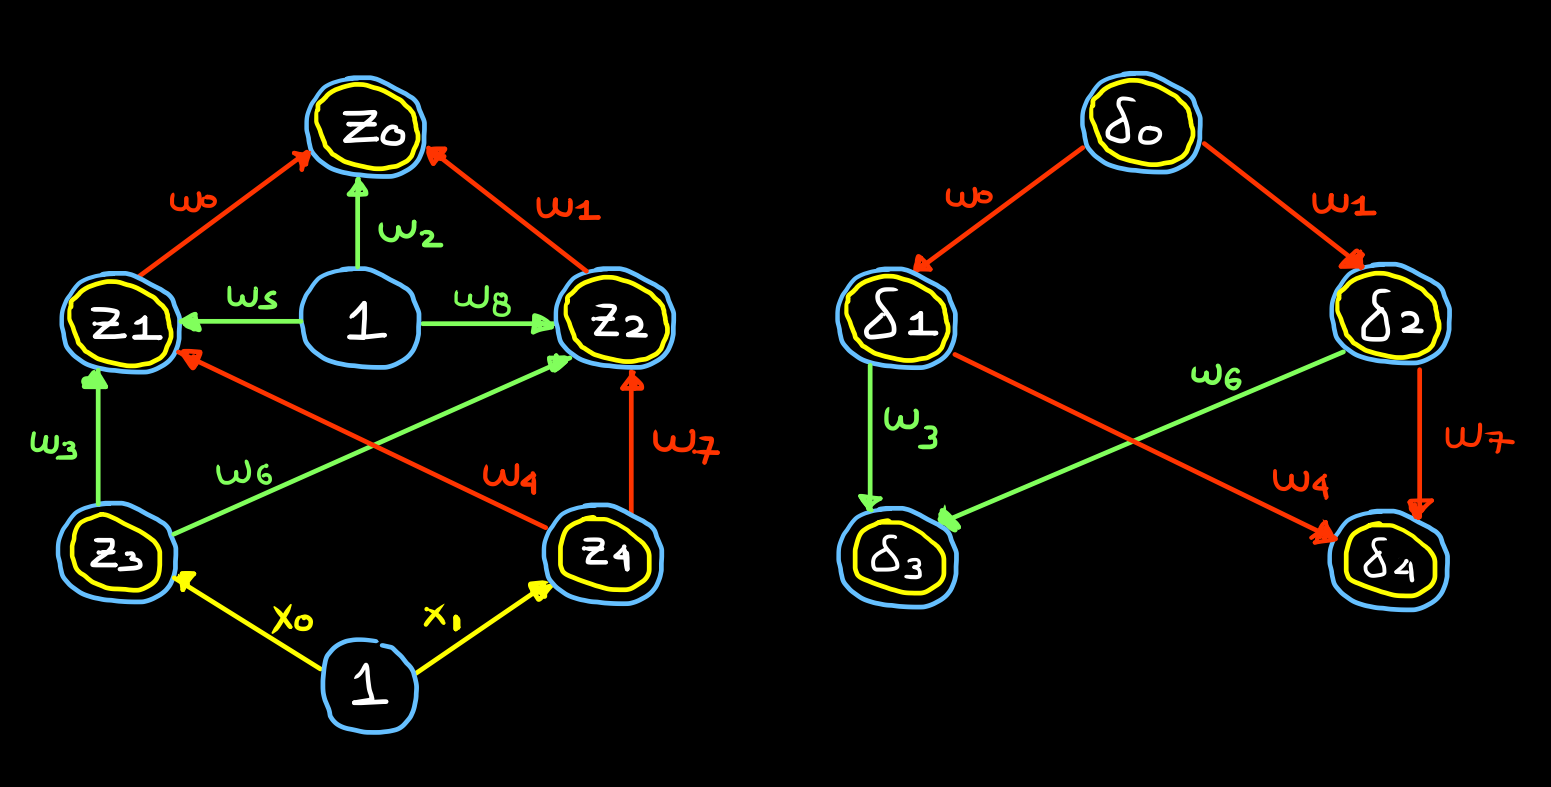

In this scenario, the $z_3$ and $z_4$ neuron will use as activation function $h(x) = x$ and its derivative would be $h'(x) = 1$. Then, we can describe the gradient using the following expressions:

$$\frac{\partial f}{\partial x_0} = \delta_{3} \cdot 1 =  \delta_{3}$$

$$\frac{\partial f}{\partial x_1} =  \delta_{4} \cdot 1 =  \delta_{4}$$

As our target is to maximize the output, we will use the function:

$$f(w,x) = - z_0 = -\sigma (a_0)$$

$$\frac{\partial f}{\partial a_0} = - \sigma(a_0) \cdot \sigma (1 - a_0)$$

In [30]:
def dL_dx(w, x):

    def derivative_relu(x):
        return 1 if x > 0 else 0
    
    def derivative_sigmoid(x):
        return sigmoid(x) * (1 - sigmoid(x))
    
    #Forwad pass
    z = np.zeros((3,))
    a = np.zeros((3,))
    a[2] = np.dot(x,w[6:8]) + w[8]
    z[2] = relu(a[2])
    a[1] = np.dot(x,w[3:5]) + w[5]
    z[1] = relu(a[1])
    a[0] = np.dot(z[1:3], w[0:2]) + w[2]
    z[0] = sigmoid(a[0])
    
    #Backward pass
    delta = np.zeros((5,))
    delta[0] = -derivative_sigmoid(a[0])
    delta[1] = derivative_relu(a[1]) * (np.dot(delta[0], w[0]))
    delta[2] = derivative_relu(a[2]) * (np.dot(delta[0], w[1]))
    delta[3] = 1 * np.dot(delta[1:3], np.array([w[3], w[6]]))        #If h(x) = x then h'(x)=1
    delta[4] = 1 * np.dot(delta[1:3], np.array([w[4], w[7]]))        #If h(x) = x then h'(x)=1
    
    #Grad for the different xi inputs
    grad = np.zeros_like(x)
    grad[0] = delta[3] * 1                                            #    (1) --x0--> z3
    grad[1] = delta[4] * 1                                            #    (1) --x1--> z4

    return grad

We can now try this using gradient descent to see if we can actually maximize the output given an static set of parameters. In each set of epochs we will track the output values in order to see if it is increasing as we expect

In [31]:
static_w = np.array([
    0.1, 0.7, 0,
    1, -0.2, 0,
    -1/5, 1/3, 0
])

x = np.array([1, -2], dtype=np.float32)
print(f"Initial x: {x.round(3)}")
print(f"Initial net output: {predict(static_w, x):.3f}\n")
n_epochs = 10001
y_values = []
lr = 0.9
for epoch in range(n_epochs):
    grad = dL_dx(static_w, x)
    y = predict(static_w, x)
    y_values.append(y)
    x = x - lr * grad
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:>5}: y = {y:.3f}, grad = {grad.round(3)}")

print(f"\nFinal x: {x.round(3)}")
print(f"Final network output: {predict(static_w, x):.3f}")

Initial x: [ 1. -2.]
Initial net output: 0.535

Epoch     0: y = 0.535, grad = [-0.025  0.005]
Epoch  1000: y = 0.864, grad = [-0.012  0.002]
Epoch  2000: y = 0.934, grad = [-0.006  0.001]
Epoch  3000: y = 0.957, grad = [-0.004  0.001]
Epoch  4000: y = 0.969, grad = [-0.003  0.001]
Epoch  5000: y = 0.976, grad = [-0.002  0.   ]
Epoch  6000: y = 0.980, grad = [-0.002  0.   ]
Epoch  7000: y = 0.983, grad = [-0.002  0.   ]
Epoch  8000: y = 0.985, grad = [-0.001  0.   ]
Epoch  9000: y = 0.987, grad = [-0.001  0.   ]
Epoch 10000: y = 0.988, grad = [-0.001  0.   ]

Final x: [ 42.406 -10.281]
Final network output: 0.988


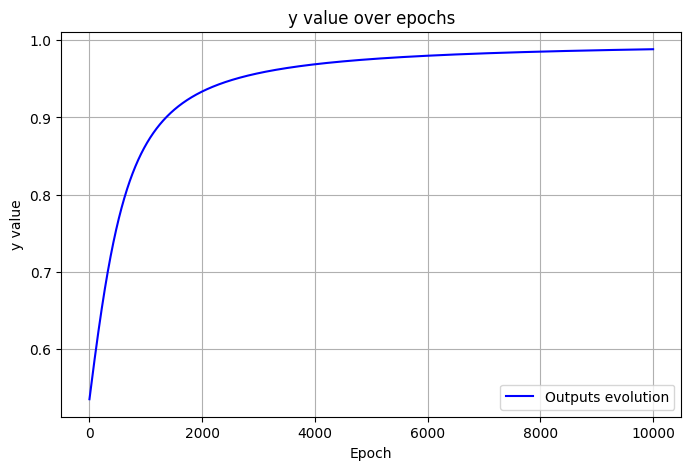

In [32]:
pl.figure(figsize=(8, 5))
pl.plot(y_values, label='Outputs evolution', color='blue')
pl.xlabel('Epoch')
pl.ylabel('y value')
pl.title('y value over epochs')
pl.legend(loc="lower right")
pl.grid(True)
pl.show()